In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import xgboost as xgb
import shap
from getpass import getuser
warnings.filterwarnings("ignore")

In [3]:
rutas_por_usuario = {
    "antmiguel": {
        "rawData": os.path.join(os.path.pardir, 'data', 'raw'),
        "externalData": os.path.join(os.path.pardir, 'data', 'external'),
        "interimData": os.path.join(os.path.pardir, 'data', 'interim'),
        "processedData": os.path.join(os.path.pardir, 'data', 'processed')
    },
    "jupyter": {
        'rawData': 'gs://ent-prd-sandbox-fdo-bucket/ent-prd-sandbox-fdo-bucket/ScoreCI/raw/',
        'externalData': 'gs://ent-prd-sandbox-fdo-bucket/ent-prd-sandbox-fdo-bucket/ScoreCI/external/',
        'interimData': 'gs://ent-prd-sandbox-fdo-bucket/ent-prd-sandbox-fdo-bucket/ScoreCI/interim/',
        'processedData': 'gs://ent-prd-sandbox-fdo-bucket/ent-prd-sandbox-fdo-bucket/ScoreCI/processed/'
    }
}

usuario = getuser()
rutas = rutas_por_usuario.get(usuario, {})

rutas

{'rawData': '..\\data\\raw',
 'externalData': '..\\data\\external',
 'interimData': '..\\data\\interim',
 'processedData': '..\\data\\processed'}

In [4]:
df = pd.read_parquet(os.path.join(rutas.get('processedData'), 'datos_entrenamiento.parquet'))

In [5]:
df.shape

(1808, 36)

In [6]:
y = df['y']
X = df.drop(columns=['y'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
X_train.shape, X.shape, y_train.shape

((1356, 35), (1808, 35), (1356,))

In [9]:
# Definir modelos y parámetros
modelos = {
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params':{
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'selection': 'rfecv'
    },
    'Huber': {
        'model': HuberRegressor(max_iter=200),
        'params': {
            'epsilon': [1.1, 1.35, 1.5, 2.0],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'fit_intercept': [True, False]
        },
        'selection': 'rfecv'
    }
}


In [10]:
# Función para entrenar modelos y evaluar rendimiento
def entrenar_modelo(nombre, modelo, params):
    print(f"Entrenando modelo: {nombre}")
    
    # Selección de características con RFECV
    selector = RFECV(estimator=modelo, step=1, cv=5)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Búsqueda de hiperparámetros
    grid_search = GridSearchCV(modelo, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)
    
    # Mejor modelo
    best_model = grid_search.best_estimator_
    
    # Evaluación en el conjunto de prueba
    y_pred = best_model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"{nombre} - Mejor configuración: {grid_search.best_params_}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}\n")
    
    return best_model, mae, rmse, r2

# Random Forest

In [ ]:
modelrf = RandomForestRegressor(random_state=42, n_estimators= 300, max_depth= 10,min_samples_split = 5, min_samples_leaf =2)

In [ ]:
modelrf.fit(X_train, y_train)

In [ ]:
y_predrf = modelrf.predict(X_test)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # Fondo más limpio y profesional

# Gráfico de dispersión
sns.scatterplot(x=y_test, y=y_predrf, alpha=0.6, color="#1f77b4", edgecolor=None, label="Predicciones")

# Línea de referencia ideal (predicción perfecta)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--", color="#FF5733", linewidth=2, label="Línea Ideal")

# Línea de ajuste (Regresión Lineal)
sns.regplot(x=y_test, y=y_predrf, scatter=False, color="black", line_kws={"linewidth": 2, "linestyle": "-"})

# Etiquetas y título mejorados
plt.xlabel("Valores Reales", fontsize=12)
plt.ylabel("Predicciones RF", fontsize=12)
plt.title("Comparación Predicciones vs Valores Reales (Random Forest)", fontsize=14, fontweight="bold")

# Agregar leyenda
plt.legend()
plt.show()

In [ ]:
residuos = y_test - y_predrf
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Error (Residuo)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores (Residuos)")
plt.show()

# Hubber

In [ ]:
modelHuber = HuberRegressor(max_iter=200, alpha=0.0001,epsilon=2.0, fit_intercept=True)

In [ ]:
modelHuber.fit(X, y)

In [ ]:
y_predHun = modelHuber.predict(X)

In [ ]:
modelHuber.coef_

In [ ]:
y_predHun.shape,y_test.shape

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # Fondo más limpio y profesional

# Gráfico de dispersión
sns.scatterplot(x=y, y=y_predHun, alpha=0.6, color="#1f77b4", edgecolor=None, label="Predicciones")

# Línea de referencia ideal (predicción perfecta)
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle="--", color="#FF5733", linewidth=2, label="Línea Ideal")

# Línea de ajuste (Regresión Lineal)
sns.regplot(x=y, y=y_predHun, scatter=False, color="black", line_kws={"linewidth": 2, "linestyle": "-"})

# Etiquetas y título mejorados
plt.xlabel("Valores Reales", fontsize=12)
plt.ylabel("Predicciones RF", fontsize=12)
plt.title("Comparación Predicciones vs Valores Reales (Huber)", fontsize=14, fontweight="bold")

# Agregar leyenda
plt.legend()
plt.show()

In [ ]:
residuos = y - y_predHun
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Error (Residuo)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores (Residuos)")
plt.show()

In [ ]:
pd.DataFrame(y_predHun).to_clipboard()

In [ ]:
y.to_clipboard()

In [ ]:
X_test.head()

# XGBoost

In [12]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
feature_importance = model.feature_importances_
features = X.columns

In [14]:
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [18]:
importance_df.to_clipboard()

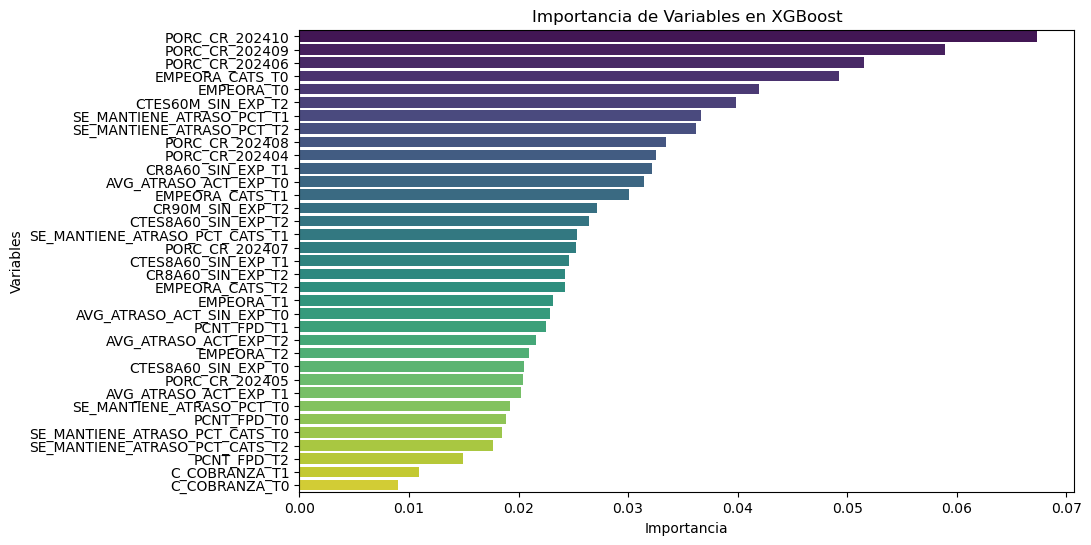

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de Variables en XGBoost')
plt.show()

In [16]:
y_pred = model.predict(X_test)

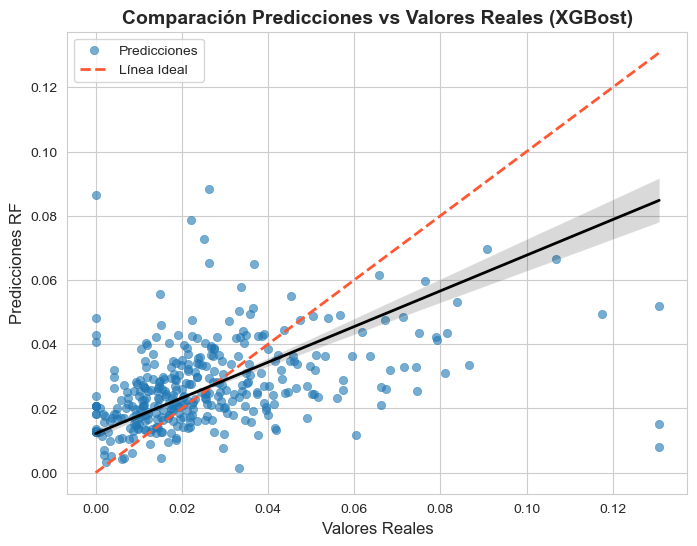

In [58]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # Fondo más limpio y profesional

# Gráfico de dispersión
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="#1f77b4", edgecolor=None, label="Predicciones")

# Línea de referencia ideal (predicción perfecta)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--", color="#FF5733", linewidth=2, label="Línea Ideal")

# Línea de ajuste (Regresión Lineal)
sns.regplot(x=y_test, y=y_predrf, scatter=False, color="black", line_kws={"linewidth": 2, "linestyle": "-"})

# Etiquetas y título mejorados
plt.xlabel("Valores Reales", fontsize=12)
plt.ylabel("Predicciones RF", fontsize=12)
plt.title("Comparación Predicciones vs Valores Reales (XGBost)", fontsize=14, fontweight="bold")

# Agregar leyenda
plt.legend()
plt.show()

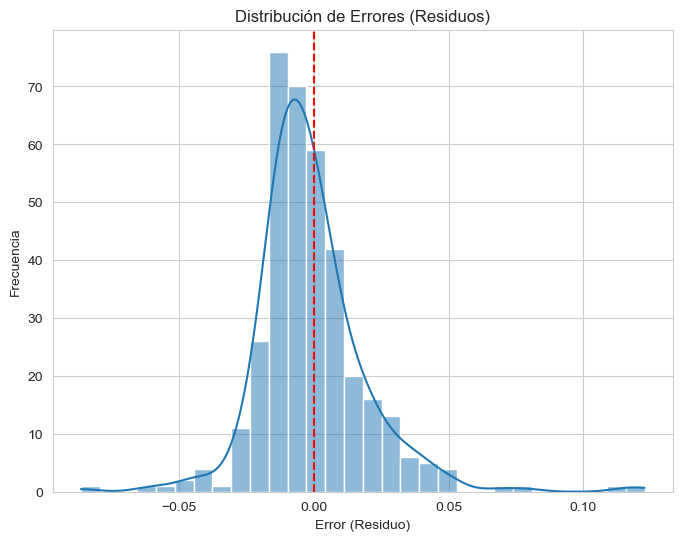

In [59]:
residuos = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Error (Residuo)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores (Residuos)")
plt.show()

In [31]:
np.mean(y_pred)*100

2.644636668264866

In [32]:
X_test.head()

,PORC_CR_202410,CTES8A60_SIN_EXP_T0,AVG_ATRASO_ACT_EXP_T0,EMPEORA_T0,EMPEORA_CATS_T0,SE_MANTIENE_ATRASO_PCT_CATS_T0,SE_MANTIENE_ATRASO_PCT_T0,PORC_CR_202409,EMPEORA_T1,EMPEORA_CATS_T1,...,EMPEORA_T2,CR90M_SIN_EXP_T2,SE_MANTIENE_ATRASO_PCT_T1,SE_MANTIENE_ATRASO_PCT_CATS_T2,EMPEORA_CATS_T2,SE_MANTIENE_ATRASO_PCT_T2,CTES60M_SIN_EXP_T2,AVG_ATRASO_ACT_SIN_EXP_T0,C_COBRANZA_T0,C_COBRANZA_T1
ASESOR_ID,,,,,,,,,,,,,,,,,,,,,
90831335,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0
7442581,0.016661,5,1.483333,0.102978,0.100000,0.033333,0.042934,0.003688,0.062591,0.060870,...,0.037158,78109.02,0.006417,0.044248,0.061947,0.028853,2,0.363636,11.0,8.0
63677392,0.052819,12,2.823529,0.036250,0.040462,0.034682,0.030601,0.051084,0.029295,0.039773,...,0.036815,35941.52,0.025385,0.017341,0.034682,0.005369,2,1.186047,10.0,12.0
74401167,0.010263,1,0.642857,0.012030,0.020833,0.000000,0.000000,0.024177,0.014679,0.021277,...,0.071264,0.00,0.023885,0.000000,0.083333,0.000000,0,0.000000,3.0,0.0
90956572,0.000000,3,1.168831,0.015394,0.028986,0.014493,0.019722,0.000000,0.066700,0.050000,...,0.052602,0.00,0.018558,0.000000,0.038462,0.000000,0,0.000000,0.0,0.0


In [33]:
y_pred

array([0.0068485 , 0.03135572, 0.02928463, 0.01845725, 0.03425348,
       0.02027314, 0.02852638, 0.02526982, 0.02113166, 0.02250362,
       0.01823542, 0.00474337, 0.01005726, 0.01731433, 0.01803486,
       0.03366093, 0.02394349, 0.02918818, 0.03094465, 0.01464263,
       0.02081785, 0.02110955, 0.03402455, 0.01390166, 0.05877772,
       0.04321714, 0.02302347, 0.03062577, 0.00631484, 0.04070042,
       0.0671765 , 0.03201519, 0.02061909, 0.02155621, 0.01874017,
       0.06586226, 0.03134828, 0.0032286 , 0.05299654, 0.02754195,
       0.02023974, 0.06513577, 0.02505108, 0.02322095, 0.03489655,
       0.0113981 , 0.01661236, 0.02719182, 0.08202526, 0.01569104,
       0.01393233, 0.01773163, 0.01544576, 0.02034266, 0.01458258,
       0.02835486, 0.08045934, 0.01240516, 0.01874017, 0.02233866,
       0.01322235, 0.02469064, 0.03643391, 0.01399076, 0.01724583,
       0.00781813, 0.027991  , 0.04613819, 0.03463249, 0.01135956,
       0.01135956, 0.01734685, 0.02086885, 0.03206666, 0.02079

In [34]:
dfPred = pd.concat([X_test, pd.DataFrame(y_pred)], axis=0)

In [35]:
X_test.reset_index(inplace=True)

In [ ]:
lsCols = ['ASESOR_ID']+list(importance_df['Feature'])

In [ ]:
X_test[lsCols]

In [ ]:
X_test[lsCols].to_csv(os.path.join(rutas.get('processedData'),'varIndep.csv'))

In [ ]:
pd.DataFrame(y_pred).to_csv(os.path.join(rutas.get('processedData'),'prediccciones.csv'))

In [ ]:
y_test.to_csv(os.path.join(rutas.get('processedData'),'real.csv'))


Iniciando seleccion de variables...

Realizando seleccion RFECV...
Numero optimo de variables segun RFECV: 8
Variables seleccionadas por RFECV:
['PORC_CR_202410', 'AVG_ATRASO_ACT_EXP_T0', 'EMPEORA_T0', 'EMPEORA_CATS_T0', 'PORC_CR_202409', 'EMPEORA_T1', 'PCNT_FPD_T0', 'EMPEORA_T2']

Procesando Random_Forest...

Optimizando hiperparametros para RandomForestRegressor...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Mejores parametros encontrados:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
mejor score (MSE negativo): -0.0004

Procesando XGBoost...

Optimizando hiperparametros para XGBRegressor...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Mejores parametros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}
mejor score (MSE negativo): -0.0004

Procesando Huber...

Optimizando hiperparametros para HuberRegressor...
Fitting 5 folds for each of 

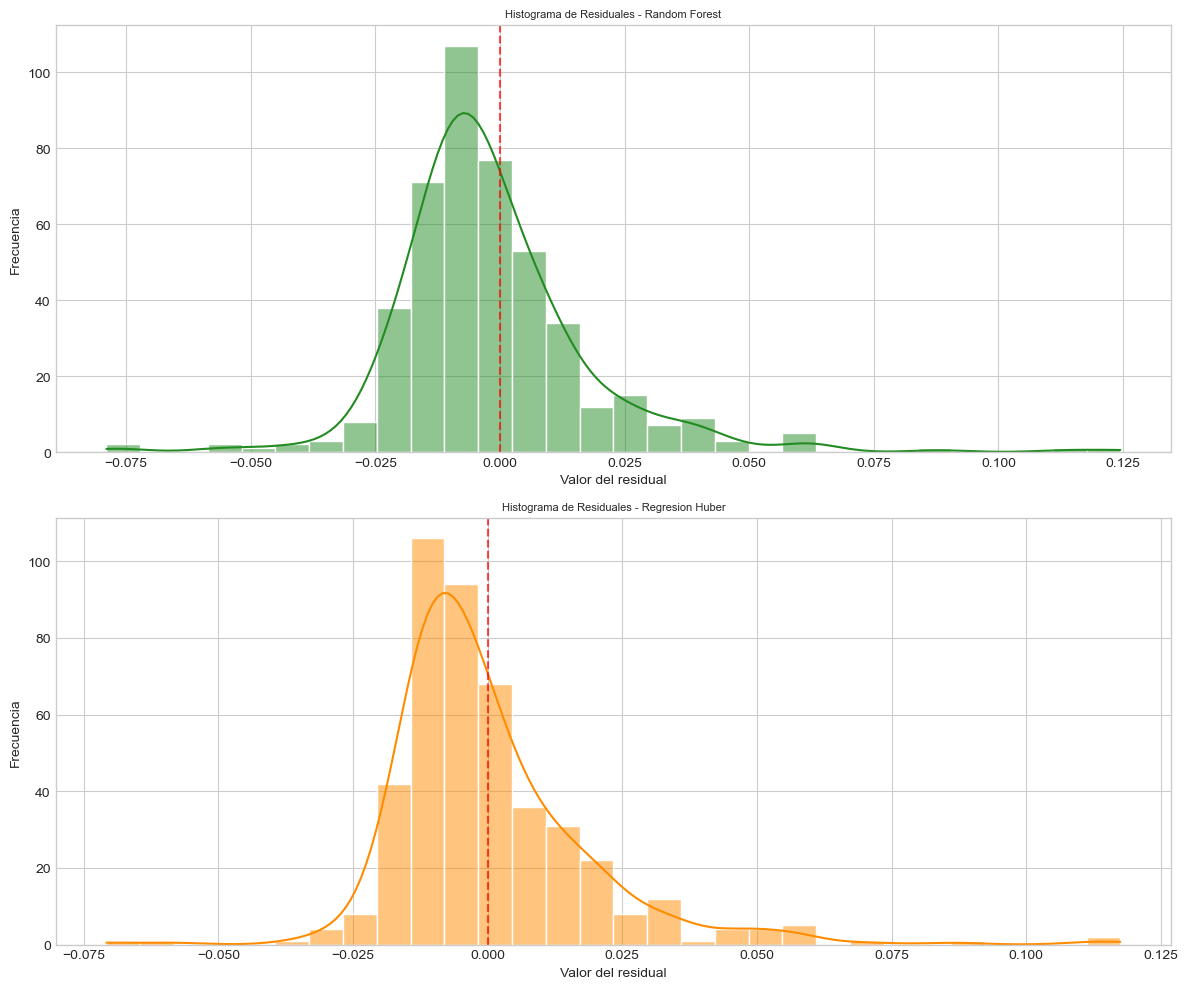

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import HuberRegressor

#########################################################################################
# FUNCIONES PARA ENTRENAMIENTO DEL MODELO:
# LEE Y PARTE DATOS EN TRAIN (75%) Y TEST (25%)
# SELECCIONA NUMERO OPTIMO DE COVARIABLES SEGUN LA IMPORTANCIA DE CADA VARIABLE (RFECV)
# OPTIMIZA HIPERPARAMETROS Y SELECCIONA LOS MEJORES PARAMETROS PARA EL AJUSTE DEL MODELO
# COMPITEN 3 MODELOS PARA ELEGIR EL MEJOR DE ACUERDO A LA PSEUDO R CUADRADA (MC FADDEN):
# RANDOM FOREST, XGBOOST Y REGRESION HUBER
#########################################################################################

# FUNCION para dividir datos en train-test y estandariza para estabilidad numerica y 
# evitar soreajuste de importancia de variables
def preparar_datos(df):
    #separo covariables y variables de respuesta
    X = df.drop('y', axis = 1)
    y = df['y']
    
    #division en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
    #estandarizacion
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #convertir a dataframe para mantener los nombres de las columnas
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


# FUNCION seleccion de variables usando metodo  RFECV 
def seleccion_variables_rfecv(X_train, X_test, y_train, method='rfecv'):
    """
    Selecciona variables usando RFECV con Random Forest 
    Parametros:
    X: DataFrame con covariables
    y: Variable de respuesta
    cv: Numero de folds para validacion cruzada
    step: Numero de variables a eliminar en cada paso
    min_features: minimo numero de variables a seleccionar

    Devuelve:
    dict: resultados del proceso de seleccion
    """
    resultados={}

    if method in ['rfecv']:
        #seleccion usando RFECV con Random Forest
        print("\nRealizando seleccion RFECV...")
        estimator = RandomForestRegressor(n_estimators=100, random_state=42)
        selector_rfecv = RFECV(
            estimator = estimator,
            step = 1,
            cv = 5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        X_train_rfecv = selector_rfecv.fit_transform(X_train, y_train)
        X_test_rfecv = selector_rfecv.transform(X_test)

        selected_features_rf = X_train.columns[selector_rfecv.support_].tolist()

        resultados['rfecv'] = {
            'X_train': X_train_rfecv,
            'X_test': X_test_rfecv,
            'n_featrues': selector_rfecv.n_features_,
            'selected_features': selected_features_rf
        }

        print(f"Numero optimo de variables segun RFECV: {selector_rfecv.n_features_}")
        print("Variables seleccionadas por RFECV:")
        print(selected_features_rf)

    return resultados

# FUNCION que calcula diferentes versiones de pseudo R cuadrada
def calcular_pseudo_r2(y_true, y_pred):
    y_mean = np.mean(y_true)
    #MCFadden's R cuadrada (pseudo R cuadrada)
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - y_mean)**2)
    mcfadden_r2 = 1 - (numerator / denominator)

    #Efron's R cuadrada
    efron_r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_mean) ** 2))

    return{
        'McFadden R2': mcfadden_r2,
        'Efron R2': efron_r2
    }

# FUNCION que realiza optimizacion de hiperparametros usando GridSearchCV (validacion cruzada
# para hiperparametros - busqueda en malla)
# genera una sucesion de valores que puede tomar un hiperparametro, por ejemmplo
# en bosques aleatorios, el numero de arboles
def optimiza_hiperparametros(X_train, y_train, modelo_base, param_grid, cv = 5):

    print(f"\nOptimizando hiperparametros para {modelo_base.__class__.__name__}...")
    grid_search = GridSearchCV(
        estimator = modelo_base,
        param_grid = param_grid,
        cv = cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1)

    grid_search.fit(X_train, y_train)

    print("\nMejores parametros encontrados:")
    print(grid_search.best_params_)
    print(f"mejor score (MSE negativo): {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

# FUNCION que evalua el modelo usando diferentes metricas
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre_modelo):
    modelo.fit(X_train, y_train)

    #predicciones
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    #calcula metricas tradicionales
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    #calcular pseudo R cuadrada
    train_pseudo_r2 = calcular_pseudo_r2(y_train, y_train_pred)
    test_pseudo_r2 = calcular_pseudo_r2(y_test, y_test_pred)

    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_pseudo_r2': train_pseudo_r2,
        'test_pseudo_r2': test_pseudo_r2,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

# FUNCION  para crear una tabla comparativa de los modelos usando diferentes metricas
def crear_tabla_comparacion(resultados_modelos):
    datos_tabla = []
    for nombre, res in resultados_modelos.items():
        datos_tabla.append({
            'Modelo': nombre,
            'Train McFadden R2': res['resultados']['train_pseudo_r2']['McFadden R2'],
            'Test McFadden R2': res['resultados']['test_pseudo_r2']['McFadden R2'],
            'Train Efron R2': res['resultados']['train_pseudo_r2']['Efron R2'],
            'Test Efron R2': res['resultados']['test_pseudo_r2']['Efron R2'],
            'Train MSE': res['resultados']['train_mse'],
            'Test MSE': res['resultados']['test_mse']
        })
    tabla = pd.DataFrame(datos_tabla)
    tabla = tabla.round(4)
    return tabla

###################### FUNCION MAIN ###################

def main():
    """
    En esta funcion se definen todos los parametros de las funciones anteriores 
    para el proceso de entrenamiento.
    """
    # preparar datos
    X_train, X_test, y_train, y_test, scaler = preparar_datos(df)

    # configura modelos y sus grids de hiperparametros
    modelos = {
        'Random_Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'selection': 'rfecv'
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state = 42),
            'params':{
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5],
                'learning_rate': [0.01, 0.1, 0.3],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            },
            'selection': 'rfecv'
        },
        'Huber': {
            'model': HuberRegressor(max_iter=200),
            'params': {
                'epsilon': [1.1, 1.35, 1.5, 2.0],
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'fit_intercept': [True, False]
            },
            'selection': 'rfecv'
        }
    }

    # Realizar seleccion de variables
    print("\nIniciando seleccion de variables...")
    resultados_seleccion = seleccion_variables_rfecv(X_train, X_test, y_train, method='rfecv')

    # Diccionario para almacenar resultados
    resultados_modelos = {}
    # Entrenar y evaluar cada modelo
    for nombre, config in modelos.items():
        print(f"\n{'='*50}")
        print(f"Procesando {nombre}...")

        # Seleccionar conjunto de datos segun metodo de seleccion
        X_train_selected = resultados_seleccion[config['selection']]['X_train']
        X_test_selected = resultados_seleccion[config['selection']]['X_test']

        # Optimizar hiperparametros si hay parametros para optimizar
        if config['params']:
            mejor_modelo = optimiza_hiperparametros(
                X_train_selected,
                y_train,
                config['model'],
                config['params']
            )
        else:
            mejor_modelo=config['model']

        # evaluar modelo
        resultados = evaluar_modelo(
            mejor_modelo,
            X_train_selected,
            X_test_selected,
            y_train,
            y_test,
            nombre
        )

        resultados_modelos[nombre] = {
            'modelo': mejor_modelo,
            'resultados': resultados
        }

    # Crear y mostrar tabla comparativa
    print("\nTabla comparativa de modelos:")
    tabla_comparacion = crear_tabla_comparacion(resultados_modelos)
    print(tabla_comparacion)

    # encontrar el mejor en test McFadden R-cuadrada
    mejor_modelo = tabla_comparacion.loc[tabla_comparacion['Test McFadden R2'].idxmax()]
    print(f"\nMejor modelo: {mejor_modelo['Modelo']}")
    print(f"Test McFadden R2: {mejor_modelo['Test McFadden R2']}")

    return resultados_modelos, resultados_seleccion, tabla_comparacion, y_test

if __name__ == "__main__":
    resultados_modelos, resultados_seleccion, tabla_comparacion, y_test = main()


# Grafico de residuales
#y_train_pred
residualesrf = y_test - resultados_modelos["Random_Forest"]["resultados"]["y_test_pred"]
residualeshub= y_test - resultados_modelos["Huber"]["resultados"]["y_test_pred"]

# configura estetica de graficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12,10))

# histograma de residuales RF
plt.subplot(2,1,1)
sns.histplot(residualesrf, kde=True, color='forestgreen', bins=30)
plt.title('Histograma de Residuales - Random Forest', fontsize=8)
plt.xlabel('Valor del residual')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
#plt.show()

# histograma de residuales Huber
plt.subplot(2,1,2)
sns.histplot(residualeshub, kde=True, color='darkorange', bins=30)
plt.title('Histograma de Residuales - Regresion Huber', fontsize=8)
plt.xlabel('Valor del residual')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()